# Python Practice Lecture 25 MATH 342W Queens College 
# - Missingness
## Author: Amir ElTabakh
## Date: May 5, 2022

## Agenda:
* Missingness
* Missforest
* Spurious Correlation

Take a look at an housing dataset from Australia:
[Take a look at an housing dataset from Australia](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot/home?select=melb_data.csv)

The description of the dataset contains information regarding context, how the data was collected, and notes on each of the variables.

Let's load the dataset into Python. I have it stored on my Github repository so one can easily access the data.

In [1]:
# importing dependencies
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error # calculates RMSE

# Data viz
import seaborn as sns
sns.set_palette(sns.color_palette("colorblind")) # setting color palette
sns.set(rc={"figure.figsize":(10, 6)}) #width=10, #height=6

In [2]:
# URL for Aus. housing data data
url = "https://raw.githubusercontent.com/sfnxboy/342-2022-Python-Practice-lectures/main/Datasets/melb_data.csv"
df = pd.read_csv(url)

# snapshot
df

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,...,2.0,2.0,652.0,NaN,1981.0,NaN,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,...,2.0,2.0,333.0,133.0,1995.0,NaN,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,...,2.0,4.0,436.0,NaN,1997.0,NaN,-37.85274,144.88738,Western Metropolitan,6380.0
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,...,1.0,5.0,866.0,157.0,1920.0,NaN,-37.85908,144.89299,Western Metropolitan,6380.0


We drop all character variables first just for expedience in the demo. If you were building a prediction model, you would scour them carefully to see if there is any signal in them you can use, and then mathematize them to metrics if so.

In [3]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = df.select_dtypes(include = numerics)
df

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
0,2,1480000.0,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,-37.79960,144.99840,4019.0
1,2,1035000.0,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,-37.80790,144.99340,4019.0
2,3,1465000.0,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,-37.80930,144.99440,4019.0
3,3,850000.0,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,-37.79690,144.99690,4019.0
4,4,1600000.0,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,-37.80720,144.99410,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,4,1245000.0,16.7,3150.0,4.0,2.0,2.0,652.0,NaN,1981.0,-37.90562,145.16761,7392.0
13576,3,1031000.0,6.8,3016.0,3.0,2.0,2.0,333.0,133.0,1995.0,-37.85927,144.87904,6380.0
13577,3,1170000.0,6.8,3016.0,3.0,2.0,4.0,436.0,NaN,1997.0,-37.85274,144.88738,6380.0
13578,4,2500000.0,6.8,3016.0,4.0,1.0,5.0,866.0,157.0,1920.0,-37.85908,144.89299,6380.0


Imagine we were trying to predict `Price`. So let's section our dataset:

In [4]:
y = df['Price']
X = df.copy()
X.drop('Price', axis=1, inplace=True)

Let's examine how many missing values there are per column.

In [5]:
# sum of missing values for y
y.isnull().sum()

0

In [6]:
# sum of missing values for all columns in X
print(X.isnull().sum())

Rooms               0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
Lattitude           0
Longtitude          0
Propertycount       0
dtype: int64


In [7]:
# sum of all missing values in all columns in X
print(f"Total Missing Values {X.isnull().sum().sum()}")

Total Missing Values 11887


Let's first create a dataframe with $p$ columns that represents missingness. We'll then filter the dataframe M for columns that contain missing data.

In [8]:
# identify missing data in X
M = X.copy()
M = M.isna().astype(int)
M

,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
0,0,0,0,0,0,0,0,1,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
13575,0,0,0,0,0,0,0,1,0,0,0,0
13576,0,0,0,0,0,0,0,0,0,0,0,0
13577,0,0,0,0,0,0,0,1,0,0,0,0
13578,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
# select only columns with missing values
M = M.loc[:, M.sum(0) > 0]
M

,Car,BuildingArea,YearBuilt
0,0,1,1
1,0,0,0
2,0,0,0
3,0,1,1
4,0,0,0
...,...,...,...
13575,0,1,0
13576,0,0,0
13577,0,1,0
13578,0,0,0


Without imputing and without using missingness as a predictor in its own right, let's see what we get with a basic linear model. For the sake of this demo we won't train test split.

In [10]:
# dropping rows with missing values
df_without_nan = df.dropna()
y_without_nan = df_without_nan['Price']
X_without_nan = df_without_nan.copy()
X_without_nan.drop('Price', axis=1, inplace=True)

# fitting model
model = LinearRegression(fit_intercept = True)
model.fit(X_without_nan, y_without_nan)

# get yhat
yhat = model.predict(X_without_nan)

# RMSE
print(mean_squared_error(y_true = y_without_nan, y_pred = yhat, squared = False))

# R^2
print(model.score(X_without_nan, y_without_nan))

427806.6016812369
0.5962475189463983


Not too bad. We've lost over 6,000 rows due to missing values. Lets introduce a way to impute for missing values.

## Missforest

MissForest is a machine learning-based imputation technique. It uses a Random Forest algorithm to do the task. It is based on an iterative approach, and at each iteration the generated predictions are better. You can read more about the theory of the algorithm, as [Andre Ye](https://towardsdatascience.com/missforest-the-best-missing-data-imputation-algorithm-4d01182aed3) made great explanations and beautiful visuals.

This process of looping through missing data points repeats several times, each iteration improving on better and better data. It’s like standing on a pile of rocks while continually adding more to raise yourself: the model uses its current position to elevate itself further.

First, the missing values are filled in using median/mode imputation. Then, we mark the missing values as ‘Predict’ and the others as training rows, which are fed into a Random Forest model trained to predict, in this case, Age based on Score. The generated prediction for that row is then filled in to produce a transformed dataset.

MissForest is also robust to noisy data and multicollinearity, since random-forests have built-in feature selection (evaluating [entropy and information gain](https://towardsdatascience.com/understanding-entropy-the-golden-measurement-of-machine-learning-4ea97c663dc3)). KNN-Impute yields poor predictions when datasets have weak predictors or heavy correlation between features.


To summarize, MisForrest is excellent because:
- Doesn’t require extensive data preparation — as a Random forest algorithm can determine which features are important
- Doesn’t require any tuning — like K in K-Nearest Neighbors
- Doesn’t care about categorical data types — Random forest knows how to handle them


Now let's impute using the package. We cannot fit Random Forest models to the entire dataset (it's 13,580 observations) so we will sample 2,000 observations for each of the trees. This is a typical strategy when fitting RF. It definitely reduces variance but increases bias. I have a powerful machine, so I won't sample.

In [11]:
# sample 2000 rows from X
#df = df.sample(2000).reset_index(drop=True)

y = df['Price']
X = df.copy()
X.drop('Price', axis=1, inplace=True)

#snapshot
X

,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
0,2,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,-37.79960,144.99840,4019.0
1,2,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,-37.80790,144.99340,4019.0
2,3,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,-37.80930,144.99440,4019.0
3,3,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,-37.79690,144.99690,4019.0
4,4,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,-37.80720,144.99410,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...
13575,4,16.7,3150.0,4.0,2.0,2.0,652.0,NaN,1981.0,-37.90562,145.16761,7392.0
13576,3,6.8,3016.0,3.0,2.0,2.0,333.0,133.0,1995.0,-37.85927,144.87904,6380.0
13577,3,6.8,3016.0,3.0,2.0,4.0,436.0,NaN,1997.0,-37.85274,144.88738,6380.0
13578,4,6.8,3016.0,4.0,1.0,5.0,866.0,157.0,1920.0,-37.85908,144.89299,6380.0


In [12]:
# pip install missforest
#!pip install missingpy

In [13]:
# if you get an error when you try to import missingpy in the cell below try this code
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

The next step is to, well, perform the imputation on X.

In [14]:
# import MissForest
from missingpy import MissForest

# Make an instance and perform the imputation
# there are several criterion, check docs for others
imputer = MissForest(criterion="squared_error")
X_imputed = imputer.fit_transform(X)

# cast as dataframe with appropriate column names
X_imputed = pd.DataFrame(X_imputed, columns = X.columns)

# snapshot
X_imputed

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
0,2.0,2.5,3067.0,2.0,1.0,1.0,202.0,86.922000,1918.92,-37.79960,144.99840,4019.0
1,2.0,2.5,3067.0,2.0,1.0,0.0,156.0,79.000000,1900.00,-37.80790,144.99340,4019.0
2,3.0,2.5,3067.0,3.0,2.0,0.0,134.0,150.000000,1900.00,-37.80930,144.99440,4019.0
3,3.0,2.5,3067.0,3.0,2.0,1.0,94.0,116.863000,1999.21,-37.79690,144.99690,4019.0
4,4.0,2.5,3067.0,3.0,1.0,2.0,120.0,142.000000,2014.00,-37.80720,144.99410,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...
13575,4.0,16.7,3150.0,4.0,2.0,2.0,652.0,202.993500,1981.00,-37.90562,145.16761,7392.0
13576,3.0,6.8,3016.0,3.0,2.0,2.0,333.0,133.000000,1995.00,-37.85927,144.87904,6380.0
13577,3.0,6.8,3016.0,3.0,2.0,4.0,436.0,211.545728,1997.00,-37.85274,144.88738,6380.0
13578,4.0,6.8,3016.0,4.0,1.0,5.0,866.0,157.000000,1920.00,-37.85908,144.89299,6380.0


In [15]:
# Feel free to read the documentation
#help(MissForest)

Lets check to see if there are any missing values in the imputed matrix.

In [16]:
# sum of missing values for all columns in X
print(X_imputed.isnull().sum())

Rooms            0
Distance         0
Postcode         0
Bedroom2         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
YearBuilt        0
Lattitude        0
Longtitude       0
Propertycount    0
dtype: int64


Now we consider our imputed dataset as the design matrix.

In [17]:
# fitting model
model = LinearRegression(fit_intercept = True)
model.fit(X_imputed, y)

# get yhat
yhat = model.predict(X_imputed)

# RMSE
print(mean_squared_error(y_true = y, y_pred = yhat, squared = False))

# R^2
print(model.score(X_imputed, y))

426959.22101769963
0.5539528209321782


We do substantially better.

Now we take our imputed dataset, combine it with our missingness indicators for a new design matrix.

In [18]:
X_imp_and_missing_dummies = pd.concat([X_imputed, M], axis = 1, ignore_index = True)

# fitting model
model = LinearRegression(fit_intercept = True)
model.fit(X_imp_and_missing_dummies, y)

# get yhat
yhat = model.predict(X_imp_and_missing_dummies)

# RMSE
print(mean_squared_error(y_true = y, y_pred = yhat, squared = False))

# R^2
print(model.score(X_imp_and_missing_dummies, y))

426782.1683606425
0.5543226804400315


Not much gain, but there seems to be something.

Are these two better models than the original model that was built with listwise deletion of observations with missingness??

Are they even comparable? It is hard to compare the two models since the first model was built with only non-missing observations which may be easy to predict on and the second was built with the observations that contained missingness. Those extra 6,750 are likely more difficult to predict on. So this is complicated...

Maybe one apples-to-apples comparison is you can replace all the missingness in the original dataset with something naive e.g. the average and then see who does better. This at least keeps the same observations.

In [19]:
X['Car'] = X['Car'].fillna(X['Car'].mean())
X['BuildingArea'] = X['BuildingArea'].fillna(X['BuildingArea'].mean())
X['YearBuilt'] = X['YearBuilt'].fillna(X['YearBuilt'].mean())

# fitting model
model = LinearRegression(fit_intercept = True)
model.fit(X, y)

# get yhat
yhat = model.predict(X)

# RMSE
print(mean_squared_error(y_true = y, y_pred = yhat, squared = False))

# R^2
print(model.score(X, y))

441189.52221491025
0.523724346099923


There is a clear gain to imputing and using is_missing dummy features to reduce delta (55.3% vs 52.4% Rsqs).

Note: this is just an illustration of best practice. It didn't necessarily have to "work".


## Spurious Correlation

Take a look at the following real data:

In [20]:
spurious = pd.DataFrame({"yearly_divorce_rate_maine_per_1000" : [5, 4.7, 4.6, 4.4, 4.3, 4.1, 4.2, 4.2, 4.2, 4.1],
                         "yearly_US_consumption_margarine_per_capita" : [8.2, 7, 6.5, 5.3, 5.2, 4, 4.6, 4.5, 4.2, 3.7]})

np.corrcoef(spurious["yearly_divorce_rate_maine_per_1000"],
            spurious["yearly_US_consumption_margarine_per_capita"])[0, 1]

0.9925584582238187

And visually,

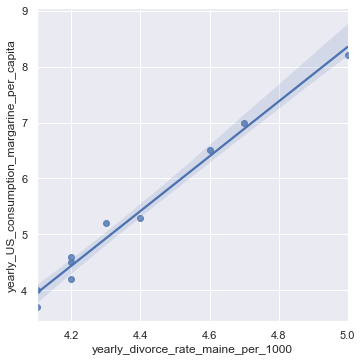

In [21]:
sns.lmplot(data = spurious,
           x = "yearly_divorce_rate_maine_per_1000",
           y = "yearly_US_consumption_margarine_per_capita")

How did this happen? 

I looked at many, many different datasets until I found something impressive!

Well, we can imagine doing the same thing. Let's look at a million datasets and find the dataset most correlated with the yearly consumption of margarine per capita:

In [22]:
y = spurious["yearly_US_consumption_margarine_per_capita"]
n = len(y)
n_sim = int(1e6)
best_abs_corr = 0
best_random_xs = []

for i in range(n_sim):
    x = np.random.normal(size = n) # default mean = 0, var = 1
    random_abs_corr = np.abs(np.corrcoef(x, y)[0, 1])
    
    if random_abs_corr > best_abs_corr:
        best_abs_corr = random_abs_corr
        best_random_xs = x
        
spurious['best_random_xs'] = best_random_xs
best_abs_corr

0.9800876961620082

And visually,

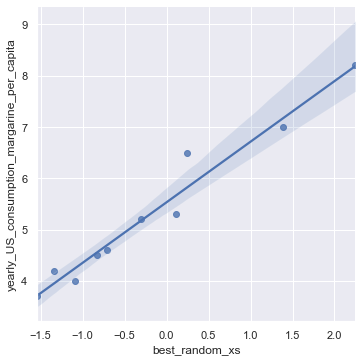

In [23]:
sns.lmplot(data = spurious,
           x = "best_random_xs",
           y = "yearly_US_consumption_margarine_per_capita")

So what's the narrative here? If you look through a gajillion random features that have no causal connection with the phenomenon $y$, you will eventually find something that "clicks". Here are a whole bunch of them:

https://www.tylervigen.com/spurious-correlations

However, these will all vanish if you keep collecting data. Anything that is built upon falsehood will crumble!